In [177]:
#questions to be answerd

#Is there a relationship between how much the world is affected by climate change and the amount of mentions in their speeches?

#To do 
#Temperature data set mixing with this
#Pre-process/Transform temperature dataset into DataFrame
#Map with color for temperature changes
#Regression for temperature and climate change mentions


## Import the databases

In [178]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data=[]


for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename),encoding="utf8")
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.tail()

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

temp = pd.read_csv('greenpeace.csv')

#set index to years and change column names for easy use
temp = temp.set_index('Year')
temp = temp.rename(columns={'Entity': 'Country', 'Surface temperature anomaly': 'Anomaly'})

#only get years 1970 and above, main data set is 1970 and above
temp = temp[temp.index >1969]
temp

Country Code  Anomaly
Year                           
1970  Afghanistan  AFG     0.70
1971  Afghanistan  AFG     0.81
1972  Afghanistan  AFG    -1.58
1973  Afghanistan  AFG     0.13
1974  Afghanistan  AFG    -0.83
...           ...  ...      ...
2013     Zimbabwe  ZWE     0.23
2014     Zimbabwe  ZWE     0.36
2015     Zimbabwe  ZWE     1.01
2016     Zimbabwe  ZWE     0.97
2017     Zimbabwe  ZWE     0.30

[9230 rows x 3 columns]

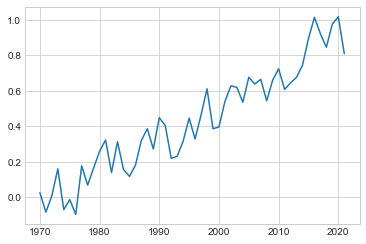

In [227]:
# can't take the average of tempereture anomaly, difference in area etc, so a different dataset for total global warming
world = pd.read_csv('globaltemp.csv')

#create extra column that gives only the year of the anomaly per month
world['Year'] = pd.DatetimeIndex(world['Day']).year

#change column names & remove 'Code'
world = world.rename(columns = {'Entity': 'Country', 'temperature_anomaly': 'Anomaly'})[['Country', 'Anomaly', 'Year']]

# date is per month, change it to anomaly per year, set index to year
world = world[world['Country'] == 'World']
world = world.groupby('Year').mean()

#only get the data from 1970 and up, because of our main data set being 1970 and higher
world = world[world.index > 1969]

plt.plot(world)


## Fit the model

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

df_copy = pd.read_pickle("climate_mentions.pkl")
df_copy['Climate Mentions Count - Absolute'] = df_copy['Climate Mentions Count'] * df_copy['Speech'].str.len()

x = df_copy.groupby("Year").mean()["Climate Mentions Count - Absolute"]
y = world[world.Anomaly.index <= 2020]

plt.plot(x, y, 'o', color='red');

groupedcount = df_copy.groupby("Year").mean()
counttemp = groupedcount.join(world)[["Climate Mentions Count", "Anomaly"]]

In [229]:
# add columns for cumulative count
counttemp["Countcum"] = counttemp["Climate Mentions Count"].cumsum()
counttemp["Anomalycum"] = counttemp["Anomaly"].cumsum()

In [230]:
import operator
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# load the dataset
data = counttemp
data = data.values

# choose the input and output variables
x, y = data[:, 1], data[:, 0]

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

# construct first degree polynomial
polynomial_features= PolynomialFeatures(degree=1)
x_poly = polynomial_features.fit_transform(x)

# construct model
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

# Calculate RMSE and R2
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("RMSE: %.5f" % (rmse))
print("R2: %.5f" % (r2))

# plot
plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

RMSE: 0.01245
R2: 0.51243


## Remove outliers

In [232]:
import seaborn as sns

#find outliers
sns.boxplot(counttemp['Climate Mentions Count'])

In [233]:
counttemp['Climate Mentions Count - Absolute'].idxmax()

KeyError: 'Climate Mentions Count - Absolute'

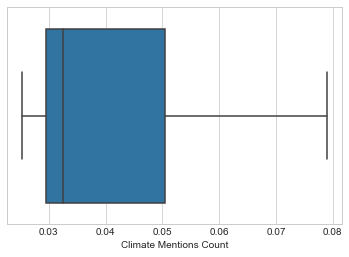

In [235]:
#manually remove outlier
counttemp = counttemp[counttemp.index != 2019]
sns.boxplot(counttemp['Climate Mentions Count'])



## Check the models again with removed outliers

RMSE: 0.01166
R2: 0.47964


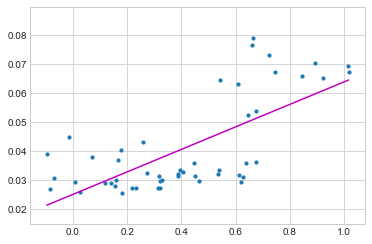

In [236]:
# load the dataset
data = counttemp
data = data.values

# choose the input and output variables
x, y = data[:, 1], data[:, 0]

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

# construct first degree polynomial
polynomial_features= PolynomialFeatures(degree=1)
x_poly = polynomial_features.fit_transform(x)

# construct model
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

# Calculate RMSE and R2
rmse1 = np.sqrt(mean_squared_error(y,y_poly_pred))
r2_1 = r2_score(y,y_poly_pred)
print("RMSE: %.5f" % (rmse1))
print("R2: %.5f" % (r2_1))

# plot
plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x1, y_poly_pred1 = zip(*sorted_zip)
plt.plot(x1, y_poly_pred1, color='m')
plt.show()

In [237]:
## Check for a higher degree polynomial fit

RMSE: 0.01015
R2: 0.60611


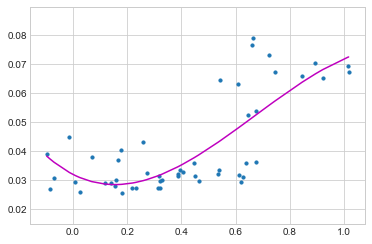

In [238]:
# load the dataset
data = counttemp
data = data.values

# choose the input and output variables
x, y = data[:, 1], data[:, 0]

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

# construct third degree polynomial
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

# construct model
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

# Calculate RMSE and R2
rmse2 = np.sqrt(mean_squared_error(y,y_poly_pred))
r2_2 = r2_score(y,y_poly_pred)
print("RMSE: %.5f" % (rmse2))
print("R2: %.5f" % (r2_2))

# plot
plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x2, y_poly_pred2 = zip(*sorted_zip)
plt.plot(x2, y_poly_pred2, color='m')
plt.show()

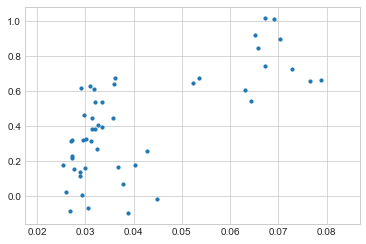

In [239]:
# choose the input and output variables
x, y = data[:, 0], data[:, 1]

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

plt.scatter(x, y, s=10)



In [240]:
# load the dataset
data = counttemp
data = data.values

# choose the input and output variables
x, y = data[:, 1], data[:, 0]

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

# construct fifth degree polynomial
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(x)

# construct model
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

# Calculate RMSE and R2
rmse3 = np.sqrt(mean_squared_error(y,y_poly_pred))
r2_3 = r2_score(y,y_poly_pred)
print("RMSE: %.5f" % (rmse3))
print("R2: %.5f" % (r2_3))

# plot
plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x3, y_poly_pred3 = zip(*sorted_zip)
plt.plot(x3, y_poly_pred3, color='m')
plt.show()

RMSE: 0.00968
R2: 0.64137


The first degree polynomial has a RMSE of 0.01166
The third degree polynomial has a RMSE of 0.01015
The fifth degree polynomial has a RMSE of 0.00968
The first degree polynomial has a R2 of 0.47964
The third degree polynomial has a R2 of 0.60611
The fifth degree polynomial has a R2 of 0.64137


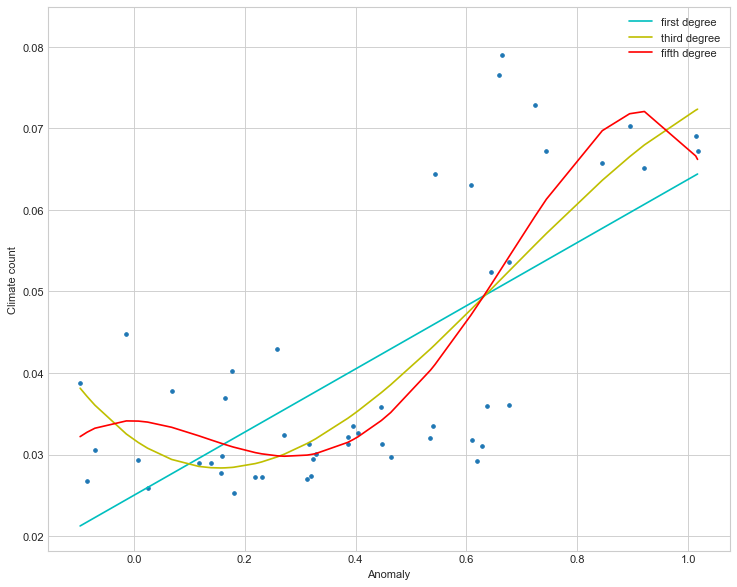

In [241]:
from matplotlib.pyplot import figure

figure(figsize=(11, 9), dpi=80)

print("The first degree polynomial has a RMSE of %.5f" % (rmse1))
print("The third degree polynomial has a RMSE of %.5f" % (rmse2))
print("The fifth degree polynomial has a RMSE of %.5f" % (rmse3))
print("The first degree polynomial has a R2 of %.5f" % (r2_1))
print("The third degree polynomial has a R2 of %.5f" % (r2_2))
print("The fifth degree polynomial has a R2 of %.5f" % (r2_3))

# plot
plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
plt.plot(x1, y_poly_pred1, color='c', label="first degree")
plt.plot(x2, y_poly_pred2, color='y', label="third degree")
plt.plot(x3, y_poly_pred3, color='r', label="fifth degree")
plt.legend()
plt.xlabel("Anomaly")
plt.ylabel("Climate count")
plt.show()